<a href="https://colab.research.google.com/github/xedinseu/detection-of-chess-board/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE%D0%B8%D1%81%D0%BA_%D1%88%D0%B0%D1%85%D0%BC%D0%B0%D1%82%D0%BD%D0%BE%D0%B9_%D0%B4%D0%BE%D1%81%D0%BA%D0%B8_%D0%BF%D0%B8%D0%BB%D0%BE%D1%82%D0%BD%D0%B0%D1%8F_%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization # слои
from tensorflow.keras.optimizers import Adam # оптимизатор
from sklearn.model_selection import train_test_split # для разделения на выборки
import matplotlib.pyplot as plt

In [3]:
xtest = np.load('/content/drive/MyDrive/Базы/idChess/xtest.npy')
ytrain = np.load('/content/drive/MyDrive/Базы/idChess/ytrain.npy')
xtrain = np.load('/content/drive/MyDrive/Базы/idChess/xtrain.npy')

пока на гугл диск грузился xtrain, посмотрим с чем мы вообще работаем

In [ ]:
xtest.shape

(5, 256, 256, 1)

In [ ]:
ytrain.shape

(15137, 8)

In [ ]:
ytrain[0]

array([0.25737846, 0.01815612, 0.20182292, 0.9902275 , 0.8830729 ,
       0.98169374, 0.78654516, 0.03677521], dtype=float32)

In [ ]:
xtest[0]

array([[[ 15.],
        [ 16.],
        [ 14.],
        ...,
        [162.],
        [165.],
        [166.]],

       [[ 15.],
        [ 15.],
        [ 16.],
        ...,
        [161.],
        [165.],
        [164.]],

       [[ 16.],
        [ 15.],
        [ 14.],
        ...,
        [157.],
        [165.],
        [166.]],

       ...,

       [[ 71.],
        [ 71.],
        [ 70.],
        ...,
        [ 35.],
        [ 33.],
        [ 32.]],

       [[ 72.],
        [ 72.],
        [ 72.],
        ...,
        [ 34.],
        [ 33.],
        [ 34.]],

       [[ 73.],
        [ 72.],
        [ 72.],
        ...,
        [ 35.],
        [ 35.],
        [ 34.]]], dtype=float32)

Рискну предположить, что x - массив, содержащий кадры съемки стола с доской преобразованные к  разрешениею 256х256 и в черно-белом формате. А в y - кооординаты 4 точек углов доски на изображении. Из этого и будем исходить

x массивы не нормализованы, надо этим занятся

In [ ]:
max(xtest[0][0]) # проверяем, это действительно похоже на оттенки серого от 0 до 255, нормализуем

array([199.], dtype=float32)

нормализуем данные

In [4]:
xtest = xtest/255

In [5]:
xtrain = xtrain/255

In [21]:
# для начала разобъем наши данные на обучающую и проверочную выборки, в соотношении 90/10. Все же нужно отслеживать как модель будет отрабатывать на данных, которые не видела.
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1)

In [6]:
# модель нейронной сети на keras, попробуем простую сверточную архитектуру
model = Sequential()

model.add(BatchNormalization(input_shape=(256,256,1)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#model.add(Conv2D(512, (2, 2), padding='same', activation='relu'))
#model.add(Conv2D(512, (2, 2), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
#model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

#model.add(Conv2D(2048, (4, 4), padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='sigmoid'))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# обучаем нейронку, выводим графики метрик
history = model.fit(xtrain,ytrain,epochs=100,batch_size=32, validation_data=(xval, yval))

plt.plot(history.history['accuracy'],label = 'Доля верных ответов на обучающейм наборе')
plt.plot(history.history['val_accuracy'],label = 'Доля верных ответов на опроверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.show()

Epoch 1/100
426/426 [==============================] - 455s 966ms/step - loss: 0.0142 - accuracy: 0.4882 - val_loss: 0.0045 - val_accuracy: 0.6017
Epoch 2/100
426/426 [==============================] - 396s 930ms/step - loss: 0.0015 - accuracy: 0.6509 - val_loss: 0.0020 - val_accuracy: 0.8045
Epoch 3/100
426/426 [==============================] - 396s 930ms/step - loss: 0.0012 - accuracy: 0.6904 - val_loss: 0.0015 - val_accuracy: 0.6546
Epoch 4/100
426/426 [==============================] - 396s 929ms/step - loss: 0.0010 - accuracy: 0.7019 - val_loss: 0.0012 - val_accuracy: 0.7933
Epoch 5/100
426/426 [==============================] - 395s 928ms/step - loss: 9.2508e-04 - accuracy: 0.7211 - val_loss: 0.0011 - val_accuracy: 0.8534
Epoch 6/100
426/426 [==============================] - 395s 928ms/step - loss: 8.5054e-04 - accuracy: 0.7310 - val_loss: 9.5385e-04 - val_accuracy: 0.7728
Epoch 7/100
426/426 [==============================] - 396s 929ms/step - loss: 7.7340e-04 - accuracy: 0.74

KeyboardInterrupt: ignored

Останавливаю обучение на этом этапе, сохраняю модель. Дальнейшие попытки улучшить точность были, но ощутимого результат не принесли.

In [ ]:
model.save('/content/drive/MyDrive/Базы/idChess/model.h5')

In [7]:
model.load_weights('/content/drive/MyDrive/Базы/idChess/model.h5')

In [ ]:
pred = model.predict(xval[None,0])
print('Предсказанные значения ',pred)
print('Реальные значения ',yval[0])

Предсказанные значения  [[0.25678915 0.0384602  0.20021799 0.9826052  0.8753261  0.9826181
  0.7746645  0.07457855]]
Реальные значения  [0.25668404 0.01858667 0.19418402 1.0153754  0.8809896  1.0135162
 0.7858507  0.06968085]


In [ ]:
pred = model.predict(xval[None,110])
print('Предсказанные значения ',pred)
print('Реальные значения ',yval[110])

Предсказанные значения  [[0.26279688 0.06834409 0.19035444 0.90789914 0.8087914  0.91174686
  0.7307103  0.08033356]]
Реальные значения  [0.20737848 0.0466999  0.12682292 0.8956314  0.7421007  0.88015604
 0.6796007  0.05480601]


Если представить результаты как чуть более понятные мне баундинг боксы, а не в координаты вершин трапеции (а в кадре квадратная доска это трапеция) то видим, что реальные и предсказанные трапеции имеют очень большуя площадь пересечения.

Писать кастомную метрику под площадь пересечения трапеций я сейчас не буду, но при необходимости серьезно работать с этой задачей оно того стоило бы.

Предсказанные значения для 0 элемента:  [[0.26990706 0.09408554 0.21018893 0.94276124 0.8179549  0.9358732
  0.7285194  0.10662499]]


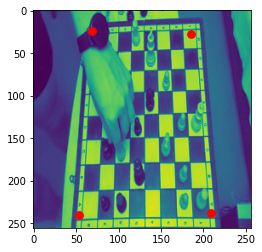

Предсказанные значения для 1 элемента:  [[0.29878208 0.12645423 0.23113942 0.8727851  0.80574757 0.8814908
  0.7284456  0.13502204]]


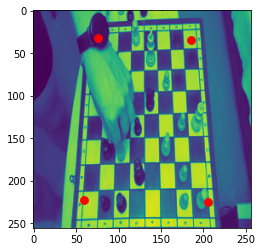

Предсказанные значения для 2 элемента:  [[0.30162638 0.06853926 0.2496838  0.8922694  0.86285734 0.9095494
  0.78649247 0.07733265]]


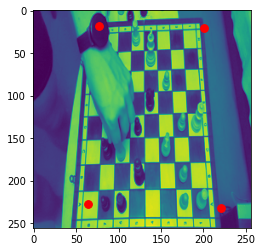

Предсказанные значения для 3 элемента:  [[0.31665593 0.10489169 0.26481417 0.8994398  0.8630518  0.91423607
  0.77668446 0.11559457]]


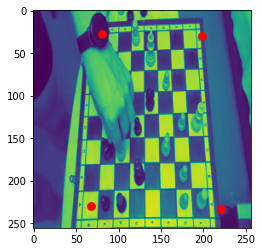

Предсказанные значения для 4 элемента:  [[0.29399592 0.05963835 0.24938872 0.9150062  0.83481103 0.9205364
  0.77171564 0.0752793 ]]


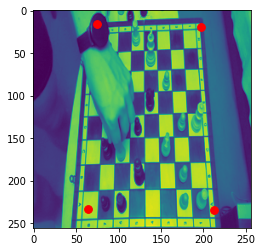

In [20]:
# выведу требуемые от меня значения предсказаний для xtest и визуализирую
for i in range(5):
  pred = model.predict(xtest[None,i])
  print('Предсказанные значения для {} элемента: '.format(i),pred)
  img = plt.imshow(xtest[0][:, :, 0])
  plt.scatter(pred[0][[0,2,4,6]]*255, pred[0][[1,3,5,7]]*255, color='red', s=60, marker='o')
  plt.show()